# K-means Model
- Author: [@vanstrouble](https://github.com/vanstrouble)

K-means is a centroid-based iterative clustering algorithm that divides a dataset into similar groups based on the distance between their centroids. The centroid, or centre of the cluster, is the mean or median of all points within the cluster, depending on the characteristics of the data.

|       Pros       |       Cons       |
| ---------------- | ------- |
| Easy to implement | Must manually chose K |
| Always converges to local minimum | Not guaranteed to find global minimum |
| Scales well to large datasets | May not perform well on data of varying density |
| Generalizes to clusters of different shapes and sizes | Clusters are biased by outliers |

In [1]:
import numpy as np
import pandas as pd
import cv2
import warnings
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, load_iris, load_breast_cancer
from sklearn.preprocessing import StandardScaler, Normalizer
from src.kmeans import Kmeans

warnings.filterwarnings('ignore')

I have developed the ```display_cluster``` function to illustrate the functionality of the KMeans clustering model, tailored for use within Jupyter Notebook environments.

The ```display_cluster``` function visualizes data distribution through a scatter plot, showcasing clusters produced by a clustering algorithm (such as KMeans) along with their centroids.

This function creates a 2D scatter plot utilizing matplotlib and seaborn for enhanced styling. Data points are color-coded based on their assigned clusters, and cluster centroids are highlighted with a cross marker. The visualization allows for customizable axis labels and a descriptive title, ensuring clarity and flexibility in presenting clustering results.

In [44]:
def display_cluster(X, model=None, num_clusters=0, **kwargs):
    """Show clusters in 2D with Jupyter Notebooks format."""
    sns.set_theme(context="notebook", style="whitegrid")

    # Verify dataset shape
    if X.shape[1] < 2:
        raise ValueError(
            "Dataset X must have at least two features (columns) for 2D visualization"
        )

    # If num_clusters is not specified, use the number of clusters in km
    if model is not None and num_clusters == 0:
        num_clusters = len(model.k)

    # Verify if the number of clusters is valid
    if model is not None and num_clusters > len(model.centroids):
        raise ValueError(
            f"The specified number of clusters ({num_clusters}) is larger than the number of clusters in the model ({len(model.centroids)})"
        )

    # Create color palette based on number of clusters
    if num_clusters > 0:
        palette = sns.color_palette("husl", num_clusters)
    else:
        palette = sns.color_palette("husl", 1)  # Generate at least one color

    alpha = 0.5
    s = 20

    if num_clusters == 0 or model is None:
        plt.scatter(X[:, 0], X[:, 1], color=palette[0], alpha=alpha, s=s)
    else:
        for i, color in enumerate(palette):
            cluster_data = X[model.labels == i]
            plt.scatter(
                cluster_data[:, 0], cluster_data[:, 1], color=color, alpha=alpha, s=s
            )
            plt.scatter(
                model.centroids[i, 0],
                model.centroids[i, 1],
                color="red",
                marker="x",
                s=100,
                edgecolor="black",
            )

    plt.title(kwargs.get("title", f"Cluster Visualization with {num_clusters} cluster/s"))
    plt.xlabel(kwargs.get("feature_x", "Default Feature x"))
    plt.ylabel(kwargs.get("feature_y", "Default Feature y"))
    plt.show()

### Determining optimium number of clusters

Let's create a new dataset that visually consists on a few clusters and try to group them.

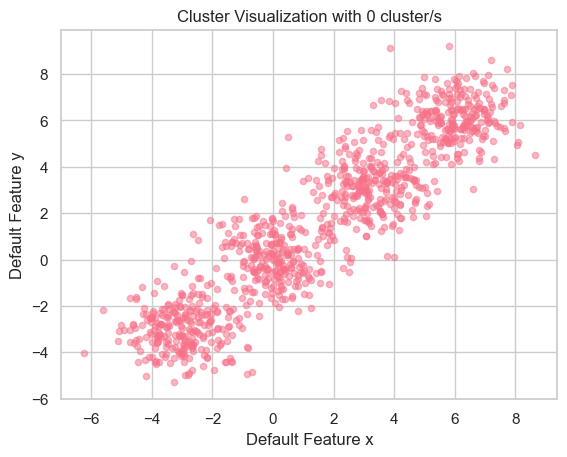

In [45]:
n_samples = 1000
n_bins = 4
centers = [(-3, -3), (0, 0), (3, 3), (6, 6)]
X, y = make_blobs(
    n_samples=n_samples,
    n_features=2,
    cluster_std=1.0,
    centers=centers,
    shuffle=False,
    random_state=42,
)

display_cluster(X)

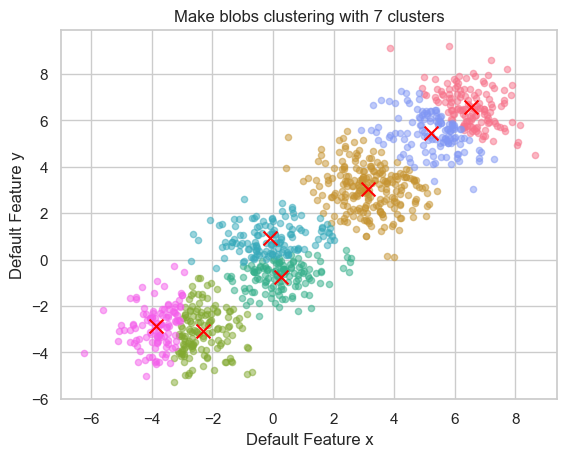

In [46]:
num_clusters = 7
km = Kmeans(k=num_clusters)
labels, centroids = km.predict(X)

display_cluster(X, km, num_clusters, title="Make blobs clustering with 7 clusters")

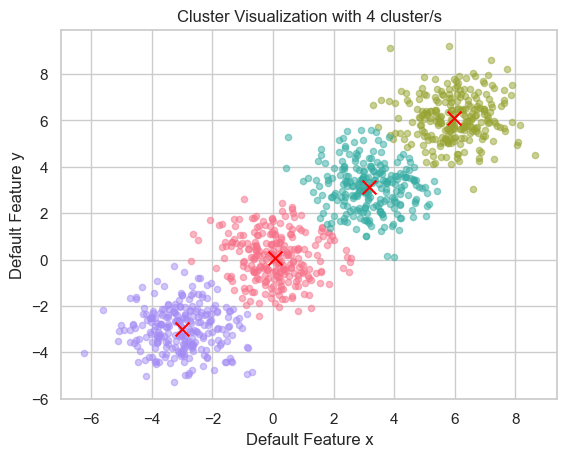

In [47]:
num_clusters = 4
km = Kmeans(k=num_clusters)
labels, centroids = km.predict(X)
display_cluster(X, km, num_clusters)

In [ ]:
### BEGIN SOLUTION
inertia = []
list_num_clusters = list(range(1,11))
for num_clusters in list_num_clusters:
    km = Kmeans(num_clusters)
    km.predict(X)
    inertia.append()

plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');
### END SOLUTION